<a href="https://colab.research.google.com/github/karencfisher/face_express/blob/main/notebooks/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data is from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The ```icml_face_data.csv``` dataset which contains a total of 34034 samples. It contains 3 columns. The target label is an integer (0, 6), the seven basic emtions:

```
['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
```

The images are stored in the 'pixels' column, as a string of 2304 integer values (0, 255) separated by spaces. These will need be coverted into an array of integer values. Subsequently, they will be needs reshaped into 3-d numpy arrays to be input to the CNN.



In [ ]:
def loadCleanData(fname):
    df = pd.read_csv(fname)
    
    # regularize capitalization and remove leading space in column headings
    fix_cols = {s : s.lower().strip() for s in df.columns.to_list()}
    df.rename(columns = fix_cols, inplace=True)
    
    # convert pixels from strings to lists of integers
    df['pixels'] = df['pixels'].apply(lambda x: [int(i) for i in x.split()])
    
    # Not using the 'usage' column, so can be dropped
    df.drop('usage', axis=1, inplace=True)
    
    return df

In [ ]:
df = loadCleanData('/content/drive/MyDrive/face express data/icml_face_data.csv')
df.head()

,emotion,pixels
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [ ]:
df_labels = pd.read_csv('https://raw.githubusercontent.com/microsoft/FERPlus/master/fer2013new.csv')
df_labels.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


In [ ]:
df_labels = df_labels[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']]
fer2013_new = pd.concat([df, df_labels], axis=1)
fer2013_new = fer2013_new[fer2013_new['NF'] < 10]

fer2013_new.head()

,emotion,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",4,0,0,1,3,2,0,0,0,0
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",6,0,1,1,0,0,0,0,2,0
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",5,0,0,3,1,0,0,0,1,0
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4,0,0,4,1,0,0,0,1,0
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",9,0,0,1,0,0,0,0,0,0


In [ ]:
# Select all but NF for use
y = fer2013_new[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']].values

# Majority rule
def makeClasses(votes):
  probs = []
  for row in range(votes.shape[0]):
    # put any contempt votes to disgust
    votes[row][5] += votes[row][7]
    y = np.argmax(votes[row][:7])
    probs.append(y)

  return np.array(probs)

In [ ]:
classes = ['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear']

In [ ]:
fer2013_new['emotion'] = makeClasses(y)
fer2013_new.head(10)

,emotion,pixels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",4,0,0,1,3,2,0,0,0,0
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",6,0,1,1,0,0,0,0,2,0
2,0,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",5,0,0,3,1,0,0,0,1,0
3,0,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",4,0,0,4,1,0,0,0,1,0
4,0,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",9,0,0,1,0,0,0,0,0,0
5,0,"[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151, ...",6,0,0,1,0,0,1,1,1,0
6,3,"[20, 17, 19, 21, 25, 38, 42, 42, 46, 54, 56, 6...",2,0,0,8,0,0,0,0,0,0
7,1,"[77, 78, 79, 79, 78, 75, 60, 55, 47, 48, 58, 7...",0,10,0,0,0,0,0,0,0,0
8,1,"[85, 84, 90, 121, 101, 102, 133, 153, 153, 169...",0,10,0,0,0,0,0,0,0,0
9,2,"[255, 254, 255, 254, 254, 179, 122, 107, 95, 1...",0,0,6,0,0,0,4,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import seaborn as sns

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(fer2013_new['pixels'],
                                                    fer2013_new['emotion'],
                                                    test_size=0.2,
                                                    stratify=fer2013_new['emotion'],
                                                    random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((28568,), (7143,), (28568,), (7143,))

In [ ]:
# transform lists of vector values into numpy arrays
x_train = np.vstack(x_train)
x_test = np.vstack(x_test)

# Convert the pandas series of target classes to numpy array
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

x_train.shape, y_train.shape

((28568, 2304), (28568,))

In [ ]:
clf = make_pipeline(PCA(n_components=150, svd_solver='randomized',
                        whiten=True),
                    SVC(class_weight='balanced'))
                    
clf.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=150,
                     random_state=None, svd_solver='randomized', tol=0.0,
                     whiten=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
score = clf.score(x_test, y_test)
print(f'Test accuracy = {round(score * 100, 2)} %')

Test accuracy = 56.32 %


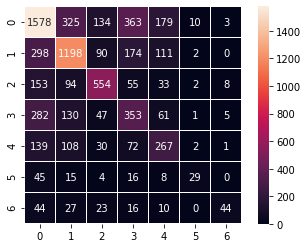

In [ ]:
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.2, square=True);


In [ ]:
classes

['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear']

In [ ]:
def showSample():
  index = np.random.randint(0, fer2013_new.shape[0])
  image = np.array(fer2013_new.iloc[index]['pixels'])

  predict = clf.predict([image])

  print(predict[0] == fer2013_new.iloc[index]['emotion'])
  print(f'Predicted {classes[predict[0]]}')
  print(f'Actual {classes[fer2013_new.iloc[index]["emotion"]]}')

  img = np.array(image).reshape(48, 48)
  plt.figure(figsize=(5,5))
  plt.imshow(img, cmap='gray')
  plt.show()

True
Predicted Sad
Actual Sad


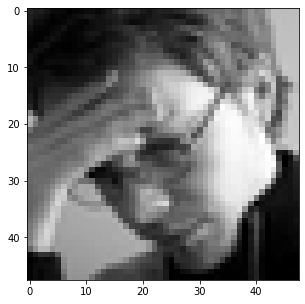

In [ ]:
showSample()

In [ ]:
import cv2
import dlib

detector = dlib.get_frontal_face_detector()

def predictEmotion(image):
  image = cv2.imread(image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 1)

  for rect in rects:
    img = gray[rect.top(): rect.bottom(), rect.left(): rect.right()]
    img = resize(img, width=48, height=48)
    print(img.shape)
    img = img.reshape(48 * 48)

    predict = clf.predict([img])

    caption = f'{classes[predict[0]]}'
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, caption,(x - 10, y - 10),
		        cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)

  plt.figure(figsize=(8, 12))
  plt.imshow(image)
    


In [ ]:
!wget https://c8.alamy.com/comp/T2MGKP/young-handsome-man-at-home-scared-in-shock-with-a-surprise-face-afraid-and-excited-with-fear-expression-T2MGKP.jpg

--2020-11-29 00:27:17--  https://c8.alamy.com/comp/T2MGKP/young-handsome-man-at-home-scared-in-shock-with-a-surprise-face-afraid-and-excited-with-fear-expression-T2MGKP.jpg
Resolving c8.alamy.com (c8.alamy.com)... 52.52.227.8, 52.9.170.225, 52.52.162.93, ...
Connecting to c8.alamy.com (c8.alamy.com)|52.52.227.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘young-handsome-man-at-home-scared-in-shock-with-a-surprise-face-afraid-and-excited-with-fear-expression-T2MGKP.jpg’

young-handsome-man-     [ <=>                ] 114.83K  --.-KB/s    in 0.1s    

Last-modified header invalid -- time-stamp ignored.
2020-11-29 00:27:17 (1.12 MB/s) - ‘young-handsome-man-at-home-scared-in-shock-with-a-surprise-face-afraid-and-excited-with-fear-expression-T2MGKP.jpg’ saved [117590]



(48, 48)


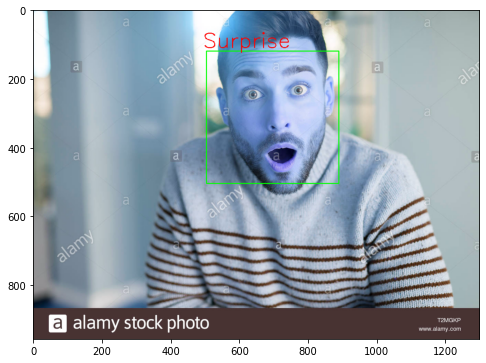

In [ ]:
predictEmotion('young-handsome-man-at-home-scared-in-shock-with-a-surprise-face-afraid-and-excited-with-fear-expression-T2MGKP.jpg')

In [ ]:
classes

['Neutral', 'Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear']

In [ ]:
!wget https://cdn.mos.cms.futurecdn.net/DMUbjq2UjJcG3umGv3Qjjd.jpeg

--2020-11-29 00:28:52--  https://cdn.mos.cms.futurecdn.net/DMUbjq2UjJcG3umGv3Qjjd.jpeg
Resolving cdn.mos.cms.futurecdn.net (cdn.mos.cms.futurecdn.net)... 8.252.221.124, 8.252.100.252, 8.252.9.252
Connecting to cdn.mos.cms.futurecdn.net (cdn.mos.cms.futurecdn.net)|8.252.221.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108735 (106K) [image/jpeg]
Saving to: ‘DMUbjq2UjJcG3umGv3Qjjd.jpeg’

DMUbjq2UjJcG3umGv3Q 100%[===================>] 106.19K  --.-KB/s    in 0.03s   

2020-11-29 00:28:52 (3.81 MB/s) - ‘DMUbjq2UjJcG3umGv3Qjjd.jpeg’ saved [108735/108735]



(48, 48)


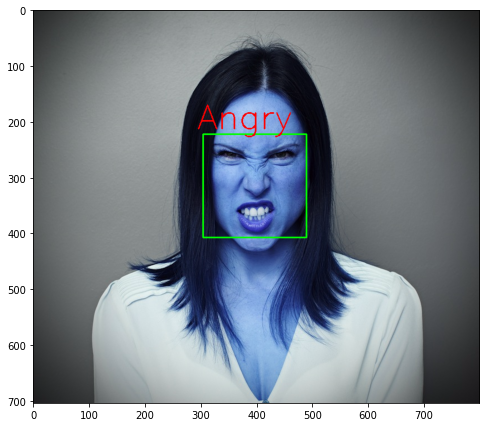

In [ ]:
predictEmotion('DMUbjq2UjJcG3umGv3Qjjd.jpeg')

In [ ]:
!wget https://i0.wp.com/cdn-prod.medicalnewstoday.com/content/images/articles/313/313264/smiling-muslim-man.jpg?w=1155&h=978

--2020-11-29 00:42:07--  https://i0.wp.com/cdn-prod.medicalnewstoday.com/content/images/articles/313/313264/smiling-muslim-man.jpg?w=1155
Resolving i0.wp.com (i0.wp.com)... 192.0.77.2
Connecting to i0.wp.com (i0.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32115 (31K) [image/jpeg]
Saving to: ‘smiling-muslim-man.jpg?w=1155.1’

smiling-muslim-man. 100%[===================>]  31.36K  --.-KB/s    in 0.03s   

2020-11-29 00:42:07 (1.19 MB/s) - ‘smiling-muslim-man.jpg?w=1155.1’ saved [32115/32115]



(48, 48)


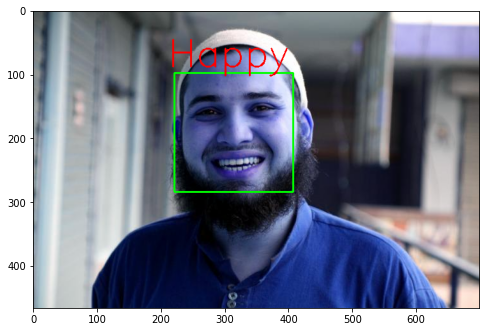

In [ ]:
predictEmotion('smiling-muslim-man.jpg?w=1155')

In [ ]:
!wget https://image.shutterstock.com/image-photo/headshot-photo-asian-man-hate-260nw-1194074005.jpg

--2020-11-29 00:29:09--  https://image.shutterstock.com/image-photo/headshot-photo-asian-man-hate-260nw-1194074005.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 104.119.185.187
Connecting to image.shutterstock.com (image.shutterstock.com)|104.119.185.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13423 (13K) [image/jpeg]
Saving to: ‘headshot-photo-asian-man-hate-260nw-1194074005.jpg’

headshot-photo-asia 100%[===================>]  13.11K  --.-KB/s    in 0s      

2020-11-29 00:29:10 (146 MB/s) - ‘headshot-photo-asian-man-hate-260nw-1194074005.jpg’ saved [13423/13423]



(48, 48)


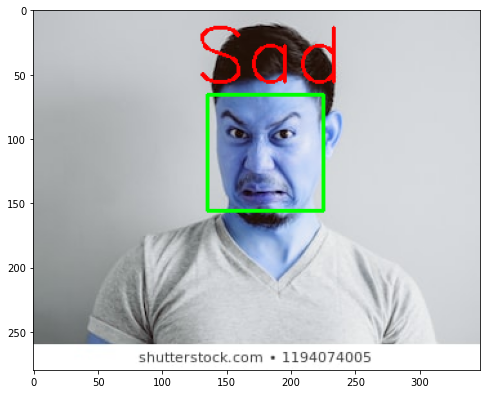

In [ ]:
predictEmotion("headshot-photo-asian-man-hate-260nw-1194074005.jpg")

In [ ]:
!wget https://previews.123rf.com/images/fredgoldstei/fredgoldstei0509/fredgoldstei050900052/242174-woman-with-sad-face.jpg

--2020-11-29 00:29:19--  https://previews.123rf.com/images/fredgoldstei/fredgoldstei0509/fredgoldstei050900052/242174-woman-with-sad-face.jpg
Resolving previews.123rf.com (previews.123rf.com)... 104.86.6.115
Connecting to previews.123rf.com (previews.123rf.com)|104.86.6.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117847 (115K) [image/jpeg]
Saving to: ‘242174-woman-with-sad-face.jpg’

242174-woman-with-s 100%[===================>] 115.08K  --.-KB/s    in 0.1s    

2020-11-29 00:29:19 (858 KB/s) - ‘242174-woman-with-sad-face.jpg’ saved [117847/117847]



(48, 48)


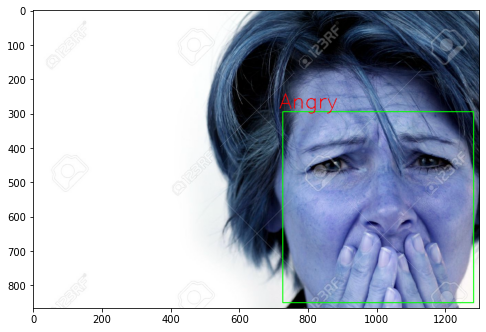

In [ ]:
predictEmotion('242174-woman-with-sad-face.jpg')

In [ ]:
import pickle

with open('/content/drive/MyDrive/face express data/svm.pickle', 'wb') as F:
  pickle.dump(clf, F)

In [ ]:
!wget https://st4.depositphotos.com/13318524/19756/i/1600/depositphotos_197562372-stock-photo-close-portrait-beautiful-young-latin.jpg


--2020-11-29 04:18:19--  https://st4.depositphotos.com/13318524/19756/i/1600/depositphotos_197562372-stock-photo-close-portrait-beautiful-young-latin.jpg
Resolving st4.depositphotos.com (st4.depositphotos.com)... 23.5.252.217
Connecting to st4.depositphotos.com (st4.depositphotos.com)|23.5.252.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171379 (167K) [image/jpeg]
Saving to: ‘depositphotos_197562372-stock-photo-close-portrait-beautiful-young-latin.jpg’

depositphotos_19756 100%[===================>] 167.36K   511KB/s    in 0.3s    

2020-11-29 04:18:20 (511 KB/s) - ‘depositphotos_197562372-stock-photo-close-portrait-beautiful-young-latin.jpg’ saved [171379/171379]



In [ ]:
predictEmotion('depositphotos_197562372-stock-photo-close-portrait-beautiful-young-latin.jpg')

(47, 48)


ValueError: ignored